In [586]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix


from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# from imblearn.over_sampling import SMOTE



In [648]:
# Must download from http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv and delete the first ","
df = pd.read_csv(".gitignore/deepsolar_tract.csv", encoding = "utf-8")


In [587]:
# Remove all deepsolar inputs

df = df.drop(columns=['solar_system_count'], axis = 1)
df = df.drop(columns=['total_panel_area'], axis = 1)
df = df.drop(columns=['solar_panel_area_per_capita'], axis =1)

df = df.drop(columns=['solar_panel_area_divided_by_area'], axis = 1)
df = df.drop(columns=['tile_count_residential'], axis = 1)
df = df.drop(columns=['tile_count_nonresidential'], axis = 1)
df = df.drop(columns=['solar_system_count_residential'], axis =1)

df = df.drop(columns=['solar_system_count_nonresidential'], axis = 1)
df = df.drop(columns=['total_panel_area_residential'], axis = 1)
df = df.drop(columns=['total_panel_area_nonresidential'], axis = 1)
df = df.drop(columns=['number_of_solar_system_per_household'], axis =1)

# Remove all object and booleans
df = df.drop(columns=['county',
                      'state'])
df = df.drop(columns=['electricity_price_transportation'], axis = 1)
df = df.drop(columns=['voting_2016_dem_win'], axis = 1)
df = df.drop(columns=['voting_2012_dem_win'], axis = 1)



In [565]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72537 entries, 0 to 72537
Data columns (total 163 columns):
tile_count                                 float64
solar_system_count                         float64
total_panel_area                           float64
fips                                       int64
average_household_income                   float64
education_bachelor                         int64
education_college                          int64
education_doctoral                         int64
education_high_school_graduate             int64
education_less_than_high_school            int64
education_master                           int64
education_population                       int64
education_professional_school              int64
employed                                   int64
gini_index                                 float64
heating_fuel_coal_coke                     int64
heating_fuel_electricity                   int64
heating_fuel_fuel_oil_kerosene             int6

# Exploring Min Max Scaling

In [554]:
df_mm = df.dropna()
df_mm = df_mm.drop('fips', axis = 1)
df_mm = df_mm.drop('tile_count', axis = 1)

col_names = list(df_mm.columns)
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df_mm)
df_mm = pd.DataFrame(df_mm, columns=col_names)

tilesLargerThanZero = range(1,4469)
df_mm['tile_count'] = df['tile_count'].replace(tilesLargerThanZero, 1)
df_mm = df_mm.dropna()
df_mm.head()v

,solar_system_count,total_panel_area,average_household_income,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,...,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate,tile_count
0,0.000000,0.000000,0.114879,0.044617,0.216119,0.009319,0.269810,0.061617,0.029395,0.143315,...,0.625,0.55,0.971429,0.0,0.0,0.595238,0.3,0.0,0.270833,0.0
1,0.001954,0.000109,0.117048,0.066965,0.186473,0.022222,0.236640,0.052998,0.051676,0.141135,...,0.625,0.55,0.971429,0.0,0.0,0.595238,0.3,0.0,0.270833,1.0
2,0.000000,0.000000,0.146143,0.050184,0.142454,0.048746,0.168151,0.042362,0.050552,0.108296,...,0.625,0.55,0.971429,0.0,0.0,0.595238,0.3,0.0,0.270833,1.0
3,0.003257,0.000278,0.150495,0.051282,0.167864,0.010753,0.150799,0.029892,0.031829,0.104833,...,0.625,0.55,0.971429,0.0,0.0,0.595238,0.3,0.0,0.270833,0.0
4,0.000000,0.000000,0.099468,0.040932,0.178260,0.017204,0.290848,0.081056,0.026587,0.140108,...,0.625,0.55,0.971429,0.0,0.0,0.595238,0.3,0.0,0.270833,1.0


### Logistic Regression Option 1: Creating target (does the county subdivision census tract have any solar panels within it) 

In [589]:
# tilesLargerThanZero = range(1,4469)
df['has_tiles'] = (df.tile_count > 0).mul(1)

In [590]:
df.has_tiles.value_counts()

1    56258
0    16279
Name: has_tiles, dtype: int64

### Logistic Regression Option 2: Creating target (does the county subdivision census tract have more than the median amount of solar panels within it)

In [431]:
tilesInLargerHalf = range(4,4469)

In [432]:
# df.tile_count = df['tile_count'].replace([1,2,3], 0)
# df.tile_count = df['tile_count'].replace(tilesInLargerHalf, 1)

df['has_tiles'] = (df.tile_count > 3).mul(1)
df['has_tiles'] = (df.tile_count <= 3).mul(0)

# Check to see target values

In [592]:
df.has_tiles.value_counts()

1    56258
0    16279
Name: has_tiles, dtype: int64

# Create a dataframe with only features that have no NaN
Note: This didn't work because I don't know the ratio for each census tract (county subdivision) 

In [419]:
no_NaN_df = pd.DataFrame()
for lessNaN in df.columns:
    if df[lessNaN].isnull().sum().sum() < 1:
        no_NaN_df[lessNaN] = df[lessNaN]
v
# df = df.dropna(axis = 1)

In [420]:
no_NaN_df.columns

Index(['tile_count', 'fips', 'education_bachelor', 'education_college',
       'education_doctoral', 'education_high_school_graduate',
       'education_less_than_high_school', 'education_master',
       'education_population', 'education_professional_school', 'employed',
       'heating_fuel_coal_coke', 'heating_fuel_electricity',
       'heating_fuel_fuel_oil_kerosene', 'heating_fuel_gas',
       'heating_fuel_housing_unit_count', 'heating_fuel_none',
       'heating_fuel_other', 'heating_fuel_solar', 'population',
       'poverty_family_below_poverty_level', 'poverty_family_count',
       'race_asian', 'race_black_africa', 'race_indian_alaska',
       'race_islander', 'race_other', 'race_two_more', 'race_white',
       'unemployed', 'electricity_price_residential',
       'electricity_price_commercial', 'electricity_price_industrial',
       'electricity_price_overall', 'electricity_consume_residential',
       'electricity_consume_commercial', 'electricity_consume_industrial',
    

In [421]:
educationDF = pd.DataFrame()
educationDF['education_less_than_high_school'] = no_NaN_df['education_less_than_high_school']
educationDF['education_doctoral'] = no_NaN_df['education_doctoral']
educationDF['education_bachelor'] = no_NaN_df['education_bachelor']


In [494]:
df = df.dropna()

# Picking Features

In [561]:
df.per_capita_income.isnull().sum()


643

In [632]:
refined_cols = ['age_18_24_rate', 'travel_time_10_19_rate', 'voting_2012_dem_percentage', 'education_bachelor_rate', 'has_tiles','gini_index']

In [633]:
pickedDF = pd.DataFrame()
pickedDF[refined_cols] = df[refined_cols]
pickedDF = pickedDF.dropna()


In [634]:
pickedDF.head()

,age_18_24_rate,travel_time_10_19_rate,voting_2012_dem_percentage,education_bachelor_rate,has_tiles,gini_index
0,0.078759,0.212693,0.429,0.125110,0,0.3490
1,0.377182,0.431373,0.429,0.190773,1,0.4074
2,0.079902,0.206927,0.429,0.190625,1,0.3926
3,0.283660,0.344913,0.429,0.185185,0,0.3949
4,0.090616,0.344376,0.429,0.195341,1,0.4463


# Starting to run Logistic Regression

In [635]:
# Define X and y
y = pickedDF['has_tiles']
X = pickedDF.drop('has_tiles', axis = 1)



# Split the data into training and test sets
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
print(y_train.value_counts(),'\n\n', y_test.value_counts())
# # SMOTE
#     smt = SMOTE()
#     X_train, y_train = smt.fit_sample(X_train, y_train)
# print(y_train.value_counts(),'\n\n', y_test.value_counts())

1    35385
0    10578
Name: has_tiles, dtype: int64 

 1    11705
0     3617
Name: has_tiles, dtype: int64


In [636]:
lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)

# Use GridSearchCV to optimize hyper parameters 

In [637]:
parameters = {'penalty':['l1', 'l2'], 'C':[.001,.01,100, 10,1e9]}
clf = GridSearchCV(LogisticRegression(solver='saga'), parameters, cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 100, 10, 1000000000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [638]:
print(clf.best_params_)

{'C': 10, 'penalty': 'l1'}


# Compare train and test data logreg for fit

In [644]:
print(clf.score(X_train, y_train))

0.7733176685594935


In [640]:
print(clf.score(X_test, y_test))

0.7661532437018665


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

Train AUC: 0.686124029137607
Test AUC: 0.6814726650941252


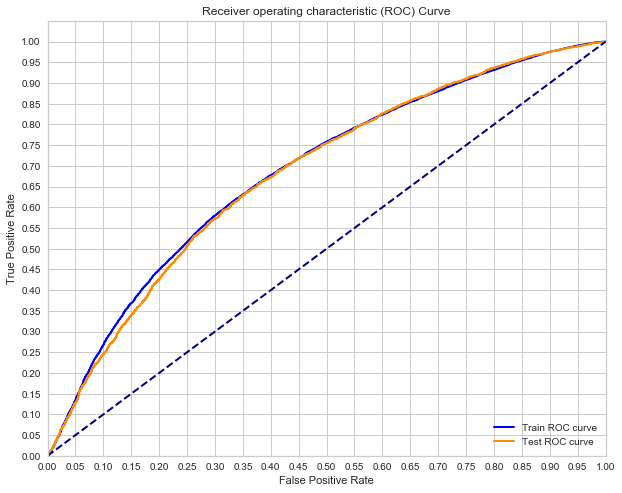

In [641]:
y_train_score = clf.decision_function(X_train)
y_test_score = clf.decision_function(X_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Use Confusion Matrix to visualize results.

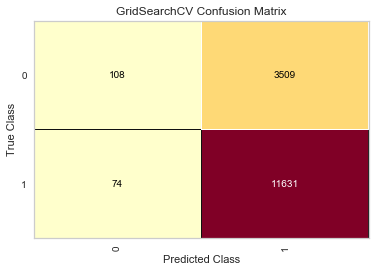

In [642]:
cm = ConfusionMatrix(clf)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

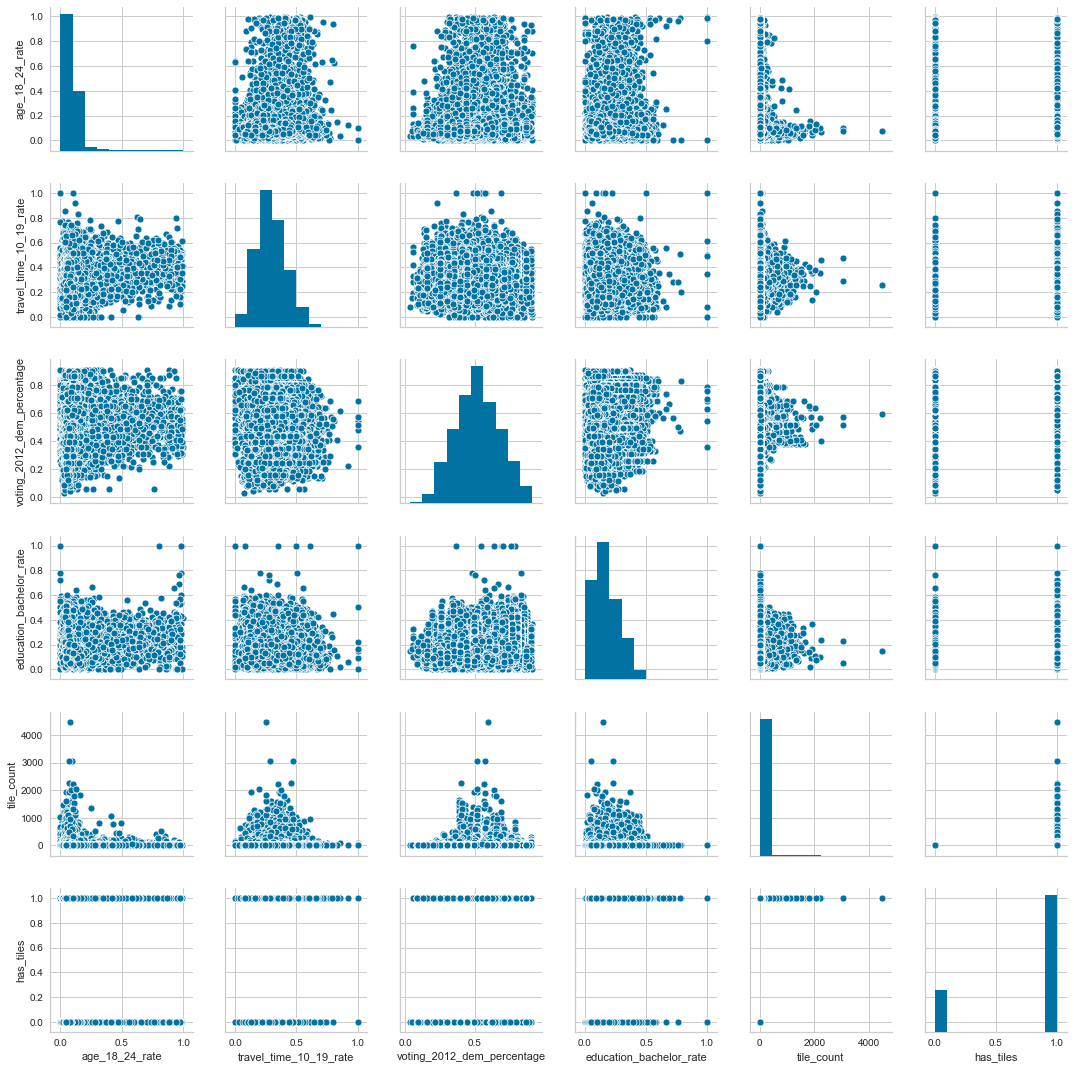

In [601]:
sns.pairplot(pickedDF[refined_cols]);

# Support Documentation 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
print(clf.best_params_)

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
SMOTE Example

https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/

